Script to process KPI time series data:
For train and test data:
1. Check for missing points in each KPI sequence, only choose sequences with no missing points.
2. Split time series based on KPI ID.

In [2]:
# Import necessary libraries
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
import zipfile

logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "axes.edgecolor": "0.3",
        "axes.linewidth": 0.8,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.titleweight": "bold",
        "legend.fontsize": 10,
        "figure.dpi": 120,
        "legend.frameon": False,
    }
)

In [3]:
# unzip raw data if not already unzipped
raw_test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.hdf.zip"
raw_train_data_path = "../../datasets/KPI/raw/phase2_train.csv.zip"
test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.hdf"
train_data_path = "../../datasets/KPI/raw/phase2_train.csv"
if not os.path.exists(test_data_path):
    with zipfile.ZipFile(raw_test_data_path, "r") as zip_ref:
        zip_ref.extractall(os.path.dirname(raw_test_data_path))
    print(f"Unzipped raw data to {os.path.dirname(raw_test_data_path)}")
if not os.path.exists(train_data_path):
    with zipfile.ZipFile(raw_train_data_path, "r") as zip_ref:
        zip_ref.extractall(os.path.dirname(raw_train_data_path))
    print(f"Unzipped raw data to {os.path.dirname(raw_train_data_path)}")

# convert test data from hdf to parquet
test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.hdf"
test_data_parquet = "../../datasets/KPI/raw/phase2_ground_truth.parquet"
# If parquet already exists, skip conversion to avoid repeated work
if os.path.exists(test_data_parquet):
    print(f"Parquet already exists: {test_data_parquet}")
else:
    print(f"Reading HDF: {test_data_path}")
    try:
        test_ts = pd.read_hdf(test_data_path)
        # Ensure KPI ID values are safe to serialize (UUIDs -> str)
        if "KPI ID" in test_ts.columns:
            test_ts["KPI ID"] = test_ts["KPI ID"].astype(str)
        test_ts = pl.from_pandas(test_ts)
        test_ts.write_parquet(  # pyright: ignore[reportAttributeAccessIssue]
            test_data_parquet
        )
        print(f"Wrote parquet: {test_data_parquet}")
    except Exception as e:
        print(f"Failed to convert HDF to parquet: {e}")

Parquet already exists: ../../datasets/KPI/raw/phase2_ground_truth.parquet


In [4]:
# Load train and test data
train_data_path = "../../datasets/KPI/raw/phase2_train.csv"
test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.parquet"
# Select KPIs with no missing values
kpi_ids = [
    "0efb375b-b902-3661-ab23-9a0bb799f4e3",
    "301c70d8-1630-35ac-8f96-bc1b6f4359ea",
    "c02607e8-7399-3dde-9d28-8a8da5e5d251",
    "e0747cad-8dc8-38a9-a9ab-855b61f5551d",
]
train_ts = (
    pl.read_csv(
        train_data_path,
        schema={
            "timestamp": pl.UInt64,
            "value": pl.Float64,
            "label": pl.UInt8,
            "KPI ID": pl.String,
        },
        truncate_ragged_lines=True,
    )
    .rename({"KPI ID": "ID"})
    .filter(pl.col("ID").is_in(kpi_ids))
)
test_ts = pl.read_parquet(test_data_path)
test_ts = (
    test_ts.with_columns(pl.col("label").cast(pl.UInt8))
    .with_columns(pl.col("timestamp").cast(pl.UInt64))
    .rename({"KPI ID": "ID"})
    .filter(pl.col("ID").is_in(kpi_ids))
)

In [5]:
# Explore train data
print(f"Train data columns: {train_ts.columns}")

print(f"Train data shape: {train_ts.shape}")

print(
    f"Train data has {train_ts['ID'].n_unique()} KPI IDs:\n{train_ts['ID'].unique().to_list()}"
)
train_anomaly_count = train_ts.filter(pl.col("label") == 1).shape[0]
print(
    f"Train data total anomaly points: {train_anomaly_count}, anomaly ratio: {train_anomaly_count / train_ts.shape[0]:.6f}"
)
train_ts.head()

Train data columns: ['timestamp', 'value', 'label', 'ID']
Train data shape: (35136, 4)
Train data has 4 KPI IDs:
['301c70d8-1630-35ac-8f96-bc1b6f4359ea', 'e0747cad-8dc8-38a9-a9ab-855b61f5551d', '0efb375b-b902-3661-ab23-9a0bb799f4e3', 'c02607e8-7399-3dde-9d28-8a8da5e5d251']
Train data total anomaly points: 226, anomaly ratio: 0.006432


timestamp,value,label,ID
u64,f64,u8,str
1469376000,0.8473,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469376300,-0.036137,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469376600,0.074292,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469376900,0.074292,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469377200,-0.036137,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"


In [6]:
# Explore test data
print(f"Test data shape: {test_ts.shape}")
print(
    f"Test data has {test_ts['ID'].n_unique()} KPI IDs:\n{test_ts['ID'].unique().to_list()}"
)
test_anomaly_count = test_ts.filter(pl.col("label") == 1).shape[0]
print(
    f"Test data total anomaly points: {test_anomaly_count}, anomaly ratio: {test_anomaly_count / test_ts.shape[0]:.6f}"
)
test_ts.head()

Test data shape: (35136, 4)
Test data has 4 KPI IDs:
['c02607e8-7399-3dde-9d28-8a8da5e5d251', '0efb375b-b902-3661-ab23-9a0bb799f4e3', '301c70d8-1630-35ac-8f96-bc1b6f4359ea', 'e0747cad-8dc8-38a9-a9ab-855b61f5551d']
Test data total anomaly points: 454, anomaly ratio: 0.012921


timestamp,value,label,ID
u64,f64,u8,str
1472011200,0.516011,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472011500,0.626441,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472011800,0.736871,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472012100,0.8473,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472012400,1.06816,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"


In [7]:
# utils for KPI stats
def compute_kpi_stats(df: pl.DataFrame) -> pl.DataFrame:
    """Compute KPI statistics from time series data.

    Args:
        df (pl.DataFrame): Input DataFrame with columns 'KPI ID', 'timestamp', 'value', 'label'.
    Returns:
        pl.DataFrame: DataFrame with computed statistics per 'KPI ID'.
    """
    # Group by 'KPI ID' and compute statistics
    return (
        df.group_by("ID")
        .agg(
            [
                pl.count().alias("Points"),
                ((pl.col("label") == 1).sum()).alias("Anomaly Points"),
                # Interval calculation
                pl.col("timestamp")
                .diff()
                .median()
                .cast(pl.UInt32)
                .alias("Interval (s)"),
            ]
        )
        .with_columns(
            # Calculate anomaly rate
            (100 * pl.col("Anomaly Points") / pl.col("Points"))
            .fill_null(0)
            .round(2)
            .alias("Anomaly Rate (%)"),
        )
        .select(
            [
                "ID",
                "Points",
                "Interval (s)",
                "Anomaly Points",
                "Anomaly Rate (%)",
            ]
        )
        .sort("ID")
    )

In [8]:
# Explore train time series per KPI ID.
train_ts = train_ts.sort(["ID", "timestamp"])

compute_kpi_stats(train_ts)

ID,Points,Interval (s),Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,f64
"""0efb375b-b902-3661-ab23-9a0bb7…",8784,300,13,0.15
"""301c70d8-1630-35ac-8f96-bc1b6f…",8784,300,114,1.3
"""c02607e8-7399-3dde-9d28-8a8da5…",8784,300,6,0.07
"""e0747cad-8dc8-38a9-a9ab-855b61…",8784,300,93,1.06


In [9]:
# Explore test time series per KPI ID.
test_ts = test_ts.sort(["ID", "timestamp"])

compute_kpi_stats(test_ts)

ID,Points,Interval (s),Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,f64
"""0efb375b-b902-3661-ab23-9a0bb7…",8784,300,71,0.81
"""301c70d8-1630-35ac-8f96-bc1b6f…",8784,300,206,2.35
"""c02607e8-7399-3dde-9d28-8a8da5…",8784,300,61,0.69
"""e0747cad-8dc8-38a9-a9ab-855b61…",8784,300,116,1.32


In [10]:
# separate time series data into multiple CSV files based on KPI ID
def separate_kpi_id(ts: pl.DataFrame, output_dir: str) -> None:
    """Separate time series data into multiple CSV files based on KPI ID.

    Args:
        ts (pl.DataFrame): Input DataFrame with columns 'ID', 'timestamp', 'value', 'label'.
    """
    if os.path.exists(output_dir):
        for f in os.listdir(output_dir):
            os.remove(os.path.join(output_dir, f))
    else:
        os.makedirs(output_dir, exist_ok=True)
    kpi_ids = ts["ID"].unique().to_list()
    for kpi_id in kpi_ids:
        kpi_ts = (
            ts.filter(pl.col("ID") == kpi_id)
            .sort("timestamp")
            .select(["timestamp", "value", "label"])
        )
        output_path = os.path.join(output_dir, f"{kpi_id}.csv")
        kpi_ts.write_csv(output_path)
        print(f"Wrote KPI {kpi_id} to {output_path}")
    sample = ts.filter(pl.col("ID") == kpi_ids[0]).select(
        ["timestamp", "value", "label"]
    )
    print(sample.head())

In [11]:
# separate train ts into multiple csv files based on KPI ID
separate_kpi_id(train_ts, "../../datasets/KPI/train")

Wrote KPI c02607e8-7399-3dde-9d28-8a8da5e5d251 to ../../datasets/KPI/train/c02607e8-7399-3dde-9d28-8a8da5e5d251.csv
Wrote KPI e0747cad-8dc8-38a9-a9ab-855b61f5551d to ../../datasets/KPI/train/e0747cad-8dc8-38a9-a9ab-855b61f5551d.csv
Wrote KPI 0efb375b-b902-3661-ab23-9a0bb799f4e3 to ../../datasets/KPI/train/0efb375b-b902-3661-ab23-9a0bb799f4e3.csv
Wrote KPI 301c70d8-1630-35ac-8f96-bc1b6f4359ea to ../../datasets/KPI/train/301c70d8-1630-35ac-8f96-bc1b6f4359ea.csv
shape: (5, 3)
┌────────────┬──────────┬───────┐
│ timestamp  ┆ value    ┆ label │
│ ---        ┆ ---      ┆ ---   │
│ u64        ┆ f64      ┆ u8    │
╞════════════╪══════════╪═══════╡
│ 1469894400 ┆ 0.216053 ┆ 0     │
│ 1469894700 ┆ 0.226608 ┆ 0     │
│ 1469895000 ┆ 0.218363 ┆ 0     │
│ 1469895300 ┆ 0.218225 ┆ 0     │
│ 1469895600 ┆ 0.205969 ┆ 0     │
└────────────┴──────────┴───────┘


In [12]:
# separate test ts into multiple csv files based on KPI ID
separate_kpi_id(test_ts, "../../datasets/KPI/test")

Wrote KPI c02607e8-7399-3dde-9d28-8a8da5e5d251 to ../../datasets/KPI/test/c02607e8-7399-3dde-9d28-8a8da5e5d251.csv
Wrote KPI 301c70d8-1630-35ac-8f96-bc1b6f4359ea to ../../datasets/KPI/test/301c70d8-1630-35ac-8f96-bc1b6f4359ea.csv
Wrote KPI e0747cad-8dc8-38a9-a9ab-855b61f5551d to ../../datasets/KPI/test/e0747cad-8dc8-38a9-a9ab-855b61f5551d.csv
Wrote KPI 0efb375b-b902-3661-ab23-9a0bb799f4e3 to ../../datasets/KPI/test/0efb375b-b902-3661-ab23-9a0bb799f4e3.csv
shape: (5, 3)
┌────────────┬──────────┬───────┐
│ timestamp  ┆ value    ┆ label │
│ ---        ┆ ---      ┆ ---   │
│ u64        ┆ f64      ┆ u8    │
╞════════════╪══════════╪═══════╡
│ 1472529600 ┆ 0.297113 ┆ 0     │
│ 1472529900 ┆ 0.290008 ┆ 0     │
│ 1472530200 ┆ 0.30937  ┆ 0     │
│ 1472530500 ┆ 0.304939 ┆ 0     │
│ 1472530800 ┆ 0.308393 ┆ 0     │
└────────────┴──────────┴───────┘


In [ ]:
def plot_kpi_timeseries(
    df: pl.DataFrame, kpi_ids: list, dataset_name: str, figsize=(20, 12)
):
    """
    plot time series for multiple KPIs with anomalies highlighted.

    Args:
        df: DataFrame with columns ['timestamp', 'value', 'label', 'ID']
        kpi_ids: List of KPI IDs to plot
        dataset_name: 'Train' or 'Test'
        figsize: Figure size
    """
    n_kpis = len(kpi_ids)
    fig, axes = plt.subplots(n_kpis, 1, figsize=figsize)

    if n_kpis == 1:
        axes = [axes]

    for _, (ax, kpi_id) in enumerate(zip(axes, kpi_ids)):
        kpi_ts = df.filter(pl.col("ID") == kpi_id).sort("timestamp")

        if kpi_ts.height == 0:
            ax.text(
                0.5,
                0.5,
                f"No data for KPI {kpi_id[:8]}",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            continue

        timestamps = pd.to_datetime(kpi_ts["timestamp"].to_numpy(), unit="s")
        values = kpi_ts["value"].to_numpy()
        labels = kpi_ts["label"].to_numpy()

        anomaly_mask = labels == 1

        ax.plot(
            timestamps,
            values,
            color="#2E86AB",
            linewidth=1.5,
            label="Normal",
            alpha=0.8,
        )

        if anomaly_mask.sum() > 0:
            ax.scatter(
                timestamps[anomaly_mask],
                values[anomaly_mask],
                color="#E63946",
                s=20,
                marker="o",
                label="Anomaly",
                zorder=5,
                edgecolors="darkred",
                linewidths=1.2,
                alpha=0.9,
            )

        kpi_short = kpi_id[:8]
        anomaly_count = anomaly_mask.sum()
        anomaly_rate = anomaly_count / len(labels) * 100

        ax.set_title(
            f"{dataset_name} - ID: {kpi_short} | "
            f"Points: {len(values):,} | "
            f"Anomalies: {anomaly_count} ({anomaly_rate:.2f}%)",
            fontsize=14,
            fontweight="bold",
            pad=10,
        )

        ax.set_xlabel("Timestamp", fontsize=12, fontweight="bold")
        ax.set_ylabel("Value", fontsize=12, fontweight="bold")

        ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
        ax.legend(loc="upper right", fontsize=10, framealpha=0.9)

        import matplotlib.dates as mdates

        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        sns.despine(ax=ax)

        stats_text = f"Mean: {values.mean():.4f}\nStd: {values.std():.4f}"
        ax.text(
            0.02,
            0.98,
            stats_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )

    plt.tight_layout()
    return fig

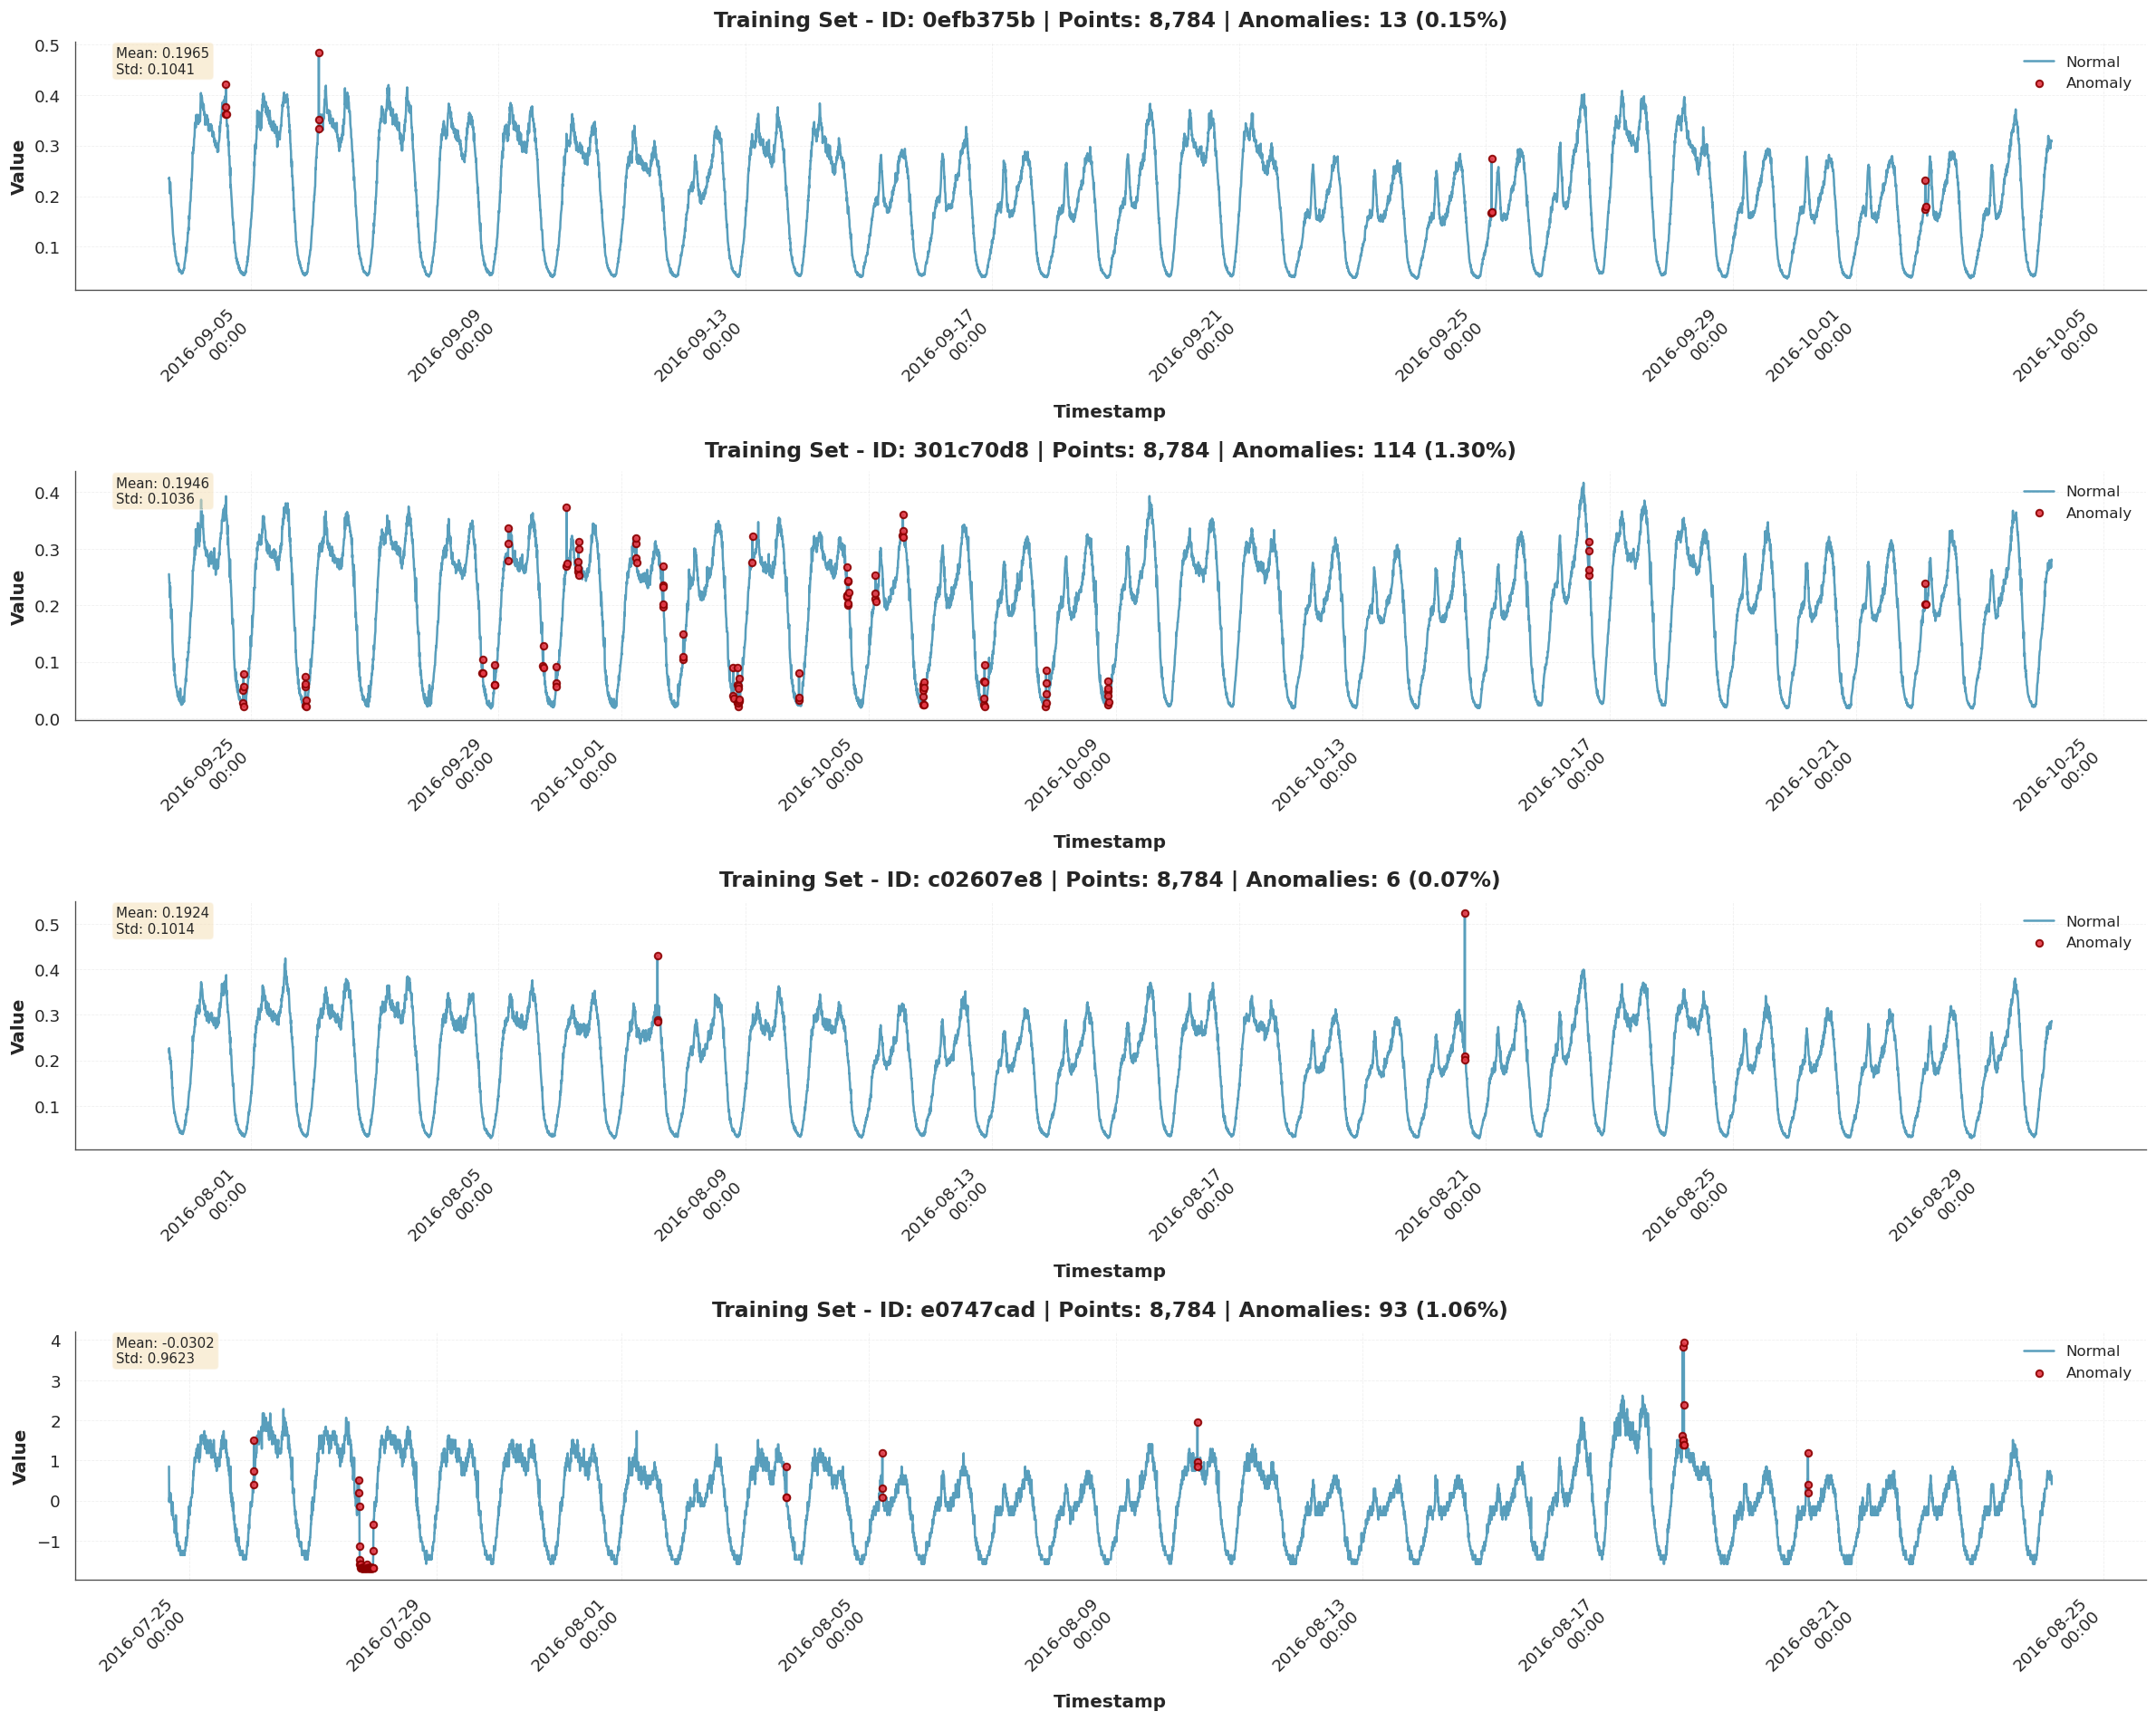

Training set visualization completed!


In [14]:
# plot training set
fig_train = plot_kpi_timeseries(
    df=train_ts,
    kpi_ids=kpi_ids,
    dataset_name="Training Set",
    figsize=(20, 16),
)

plt.show()
print("Training set visualization completed!")

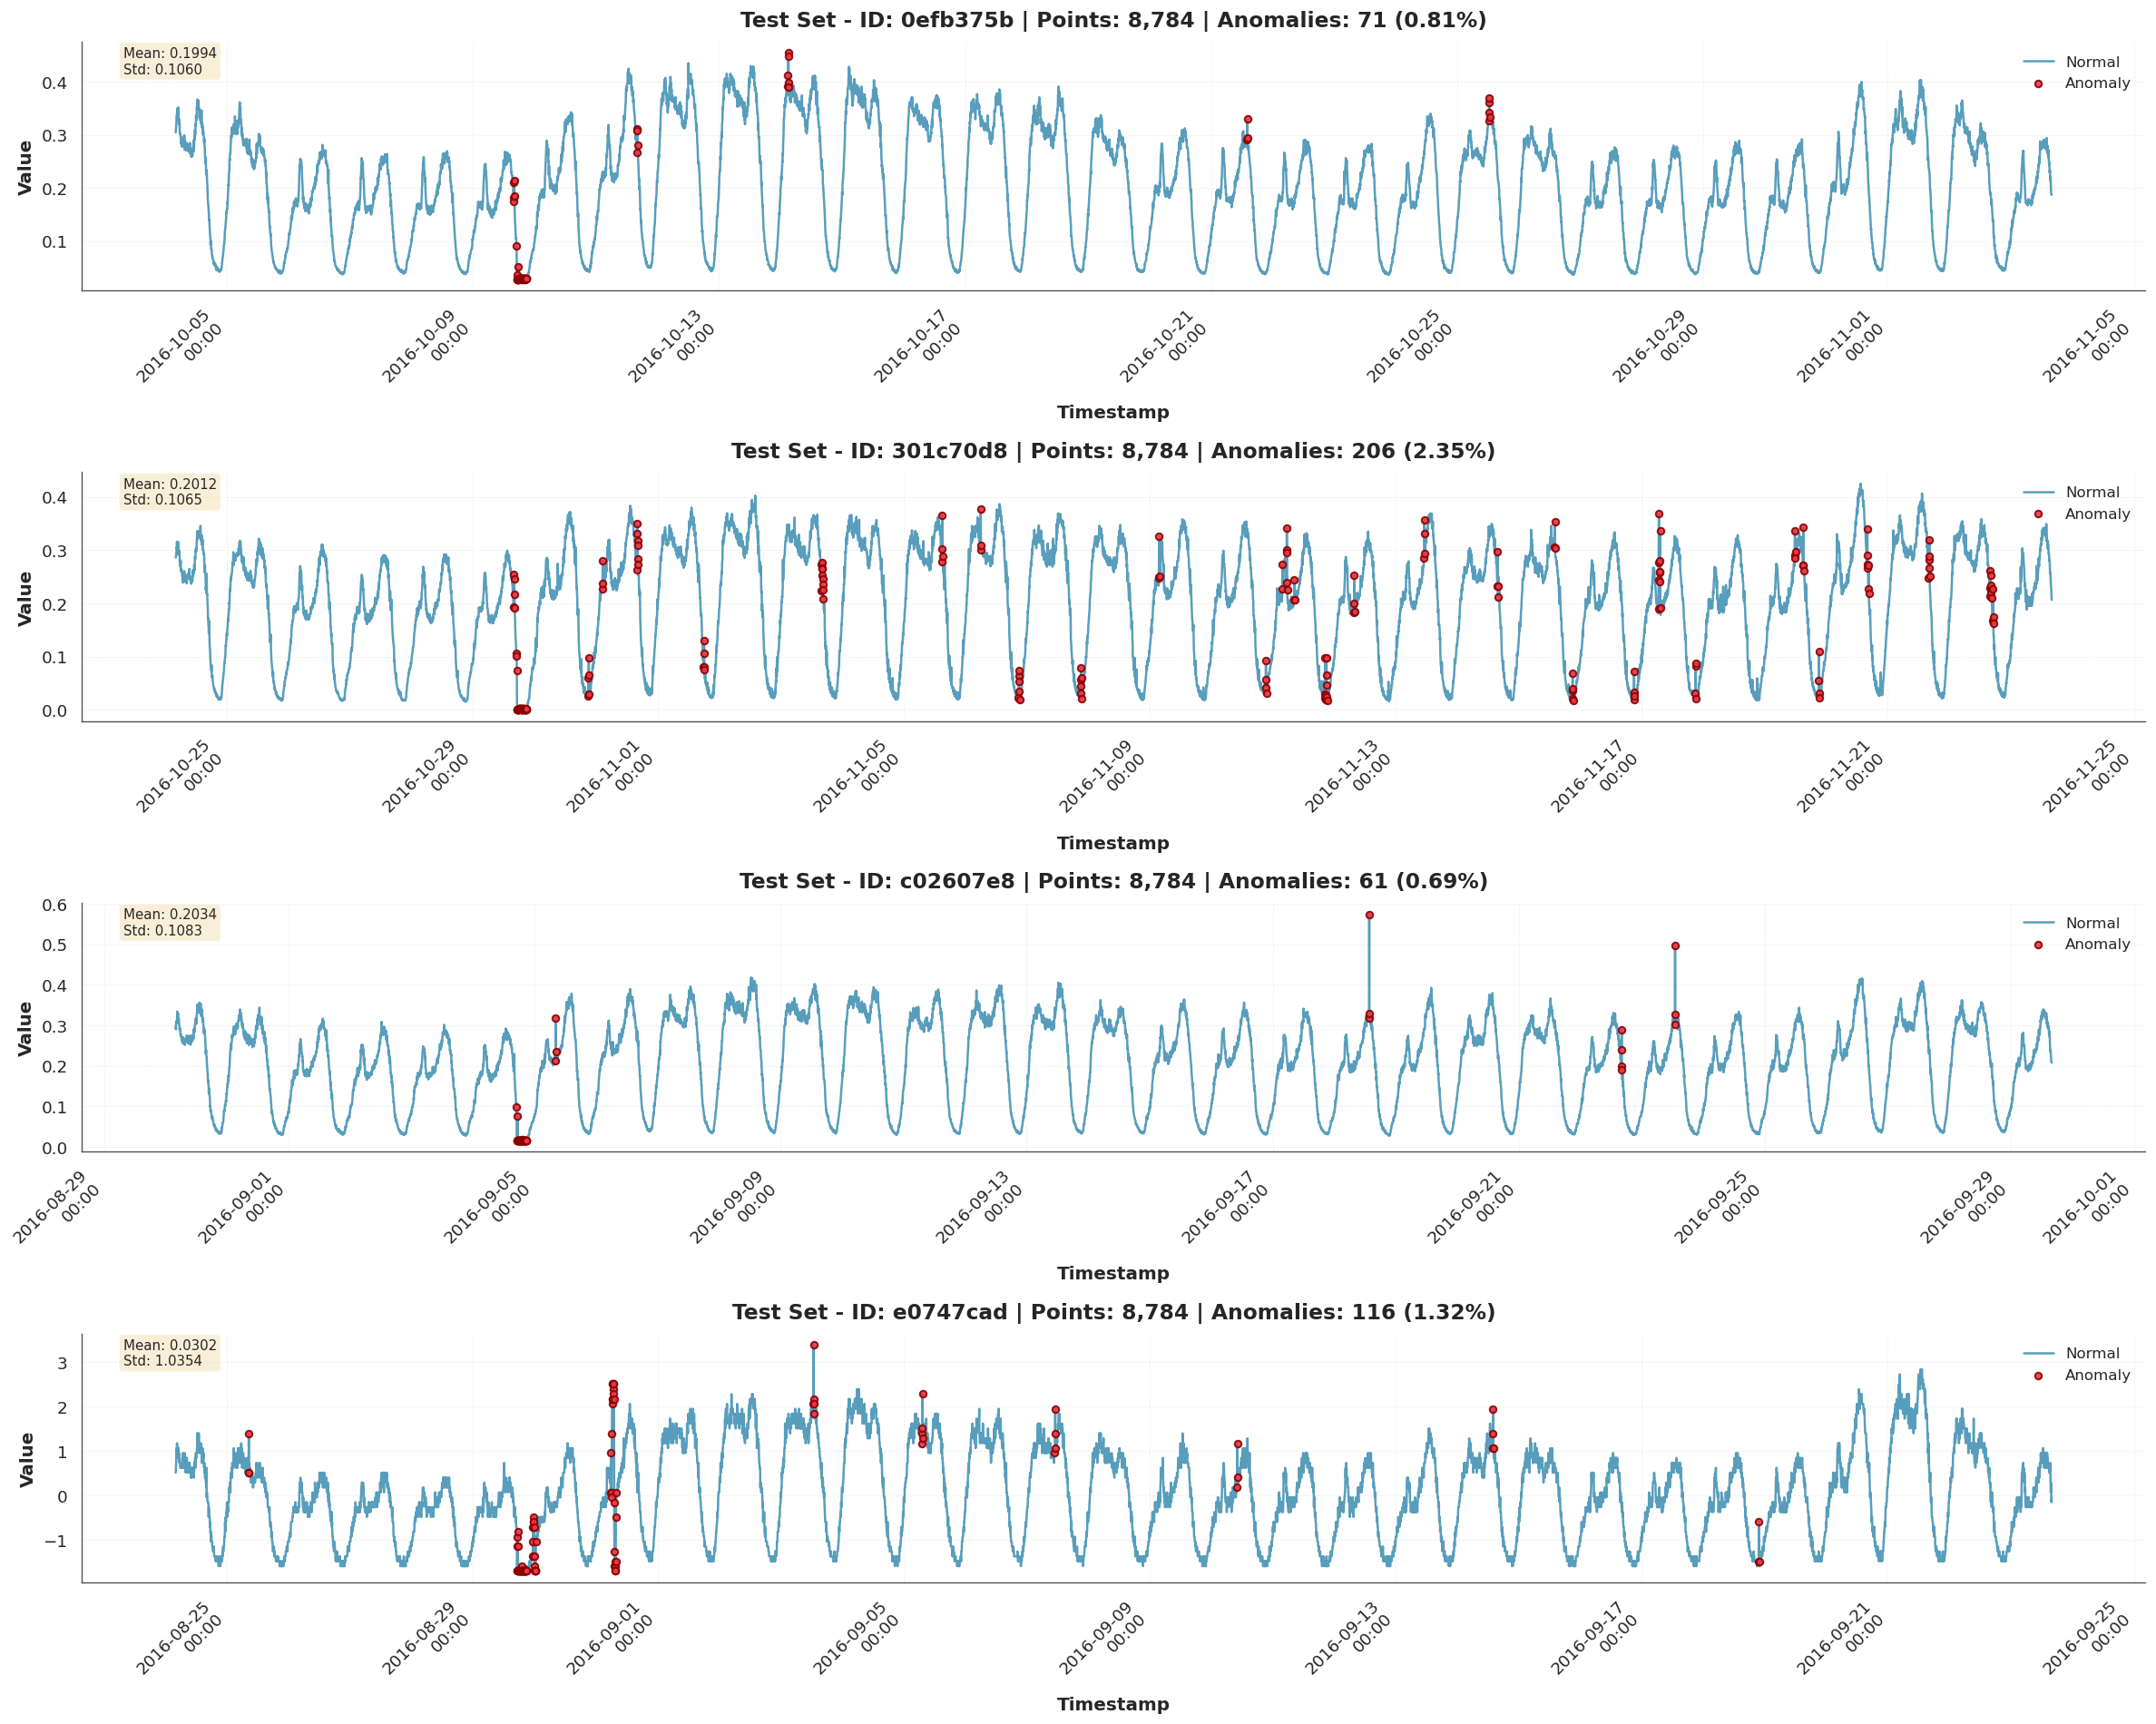

Test set visualization completed!


In [15]:
# plot test set
fig_test = plot_kpi_timeseries(
    df=test_ts,
    kpi_ids=kpi_ids,
    dataset_name="Test Set",
    figsize=(20, 16),
)

plt.show()
print("Test set visualization completed!")